##Harsh Mahajan J027
##Akash Patil J036

##  PySpark setup

In [13]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/nul
!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark


In [14]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"
import findspark
findspark.init()
findspark.find()

'/content/spark-3.1.1-bin-hadoop2.7'

## Download movie lens data:  
https://www.kaggle.com/grouplens/movielens-20m-dataset?select=movie.csv

In [15]:
! pip install -q kaggle

In [16]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harshgmahajan","key":"7374cf43367a136f94493faa148f801b"}'}

In [17]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              223KB  2021-04-09 08:39:14           2297  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           1332  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1013  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19            479  
promptcloud/care

In [18]:
!kaggle datasets download -d grouplens/movielens-20m-dataset

 94% 184M/195M [00:01<00:00, 110MB/s]
100% 195M/195M [00:01<00:00, 116MB/s]


In [19]:
!unzip /content/movielens-20m-dataset.zip

Archive:  /content/movielens-20m-dataset.zip
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: link.csv                
  inflating: movie.csv               
  inflating: rating.csv              
  inflating: tag.csv                 


# Movie Recommendation using PySpark

In [20]:
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [21]:
from pyspark.sql.functions import col

In [22]:
from pyspark.sql.functions import lit

In [23]:
def get_mat_sparsity(ratings):
    # Count the total number of ratings in the dataset
    count_nonzero = ratings.select("rating").count()

    # Count the number of distinct userIds and distinct movieIds
    total_elements = ratings.select("userId").distinct().count() * ratings.select("movieId").distinct().count()

    # Divide the numerator by the denominator
    sparsity = (1.0 - (count_nonzero *1.0)/total_elements)*100
    print("The ratings dataframe is ", "%.2f" % sparsity + "% sparse.")

In [24]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Recommendations').getOrCreate()
movies = spark.read.csv("movie.csv",header=True)
ratings = spark.read.csv("rating.csv",header=True)
ratings.show()

+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|      2|   3.5|2005-04-02 23:53:47|
|     1|     29|   3.5|2005-04-02 23:31:16|
|     1|     32|   3.5|2005-04-02 23:33:39|
|     1|     47|   3.5|2005-04-02 23:32:07|
|     1|     50|   3.5|2005-04-02 23:29:40|
|     1|    112|   3.5|2004-09-10 03:09:00|
|     1|    151|     4|2004-09-10 03:08:54|
|     1|    223|     4|2005-04-02 23:46:13|
|     1|    253|     4|2005-04-02 23:35:40|
|     1|    260|     4|2005-04-02 23:33:46|
|     1|    293|     4|2005-04-02 23:31:43|
|     1|    296|     4|2005-04-02 23:32:47|
|     1|    318|     4|2005-04-02 23:33:18|
|     1|    337|   3.5|2004-09-10 03:08:29|
|     1|    367|   3.5|2005-04-02 23:53:00|
|     1|    541|     4|2005-04-02 23:30:03|
|     1|    589|   3.5|2005-04-02 23:45:57|
|     1|    593|   3.5|2005-04-02 23:31:01|
|     1|    653|     3|2004-09-10 03:08:11|
|     1|    919|   3.5|2004-09-1

In [25]:
movies.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [26]:
ratings = ratings.\
          withColumn('userId', col('userId').cast('integer')).\
          withColumn('movieId', col('MovieId').cast('integer')).\
          withColumn('rating', col('rating').cast('float')).\
          drop('timestamp')

ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      2|   3.5|
|     1|     29|   3.5|
|     1|     32|   3.5|
|     1|     47|   3.5|
|     1|     50|   3.5|
|     1|    112|   3.5|
|     1|    151|   4.0|
|     1|    223|   4.0|
|     1|    253|   4.0|
|     1|    260|   4.0|
|     1|    293|   4.0|
|     1|    296|   4.0|
|     1|    318|   4.0|
|     1|    337|   3.5|
|     1|    367|   3.5|
|     1|    541|   4.0|
|     1|    589|   3.5|
|     1|    593|   3.5|
|     1|    653|   3.0|
|     1|    919|   3.5|
+------+-------+------+
only showing top 20 rows



In [27]:
movie_ratings = ratings.join(movies, ['movieId'], 'left')

In [28]:
get_mat_sparsity(ratings)

The ratings dataframe is  99.46% sparse.


In [29]:
(train, test) = ratings.randomSplit([0.8, 0.2], seed = 1234)

In [30]:
# def get_binary_data(ratings):
#   ratings = ratings.withColumn('binary', lit(1))
#   userIds = ratings.select('userId').distinct()
#   movieIds = ratings.select('movieId').distinct()

#   user_movie = userIds.crossJoin(movieIds).join(ratings, ['userId', 'movieId'], "left")
#   user_movie = user_movie.select(['userId', 'movieid', 'binary']).fillna(0)
#   return user_movie

# user_movie = get_binary_data(ratings)
# user_movie

In [31]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [32]:
als = ALS(
            userCol = 'userId',
          itemCol = 'movieId',
          ratingCol = 'rating',
          nonnegative = True,
          implicitPrefs = False,
          coldStartStrategy = 'drop'

)

In [33]:
type(als)

pyspark.ml.recommendation.ALS

In [34]:
param_grid = ParamGridBuilder()\
              .addGrid(als.rank,[50])\
              .addGrid(als.regParam,[.15])\
              .build()



evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol= 'prediction')

print(f'Total models = {len(param_grid)}')

Total models = 1


In [35]:
cv = CrossValidator(estimator=als,
                    estimatorParamMaps=param_grid,
                    evaluator = evaluator,
                    numFolds=5)

In [36]:
train.dtypes

[('userId', 'int'), ('movieId', 'int'), ('rating', 'float')]

In [37]:
model = cv.fit(train)
best_model = model.bestModel

In [38]:
# Print best_model
print(type(best_model))

# Complete the code below to extract the ALS model parameters
print("**Best Model**")

print("  Rank:", best_model._java_obj.parent().getRank())

print("  MaxIter:", best_model._java_obj.parent().getMaxIter())
print("  RegParam:", best_model._java_obj.parent().getRegParam())

<class 'pyspark.ml.recommendation.ALSModel'>
**Best Model**
  Rank: 50
  MaxIter: 10
  RegParam: 0.15


In [39]:
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.8415014622149738


In [40]:
test_predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|136222|    148|   2.0|  2.491131|
|137949|    148|   4.0| 3.0596452|
| 88527|    148|   2.0|  2.393355|
| 96427|    148|   3.0| 2.9514785|
| 36821|    148|   4.0|  2.921179|
| 32882|    148|   3.0| 2.8045843|
| 46146|    148|   2.0| 1.9020759|
| 54726|    148|   5.0| 3.2115035|
|  3990|    148|   4.0| 2.3936944|
| 80693|    148|   1.0|  2.821476|
| 64843|    148|   3.5| 2.6998665|
| 81300|    148|   1.0| 2.8312736|
| 48644|    148|   3.0|  2.976367|
| 62028|    148|   3.0|  2.754606|
|128653|    148|   2.0| 2.4576988|
|  9084|    148|   2.0| 2.9356146|
| 70446|    148|   2.0| 2.9667842|
| 75359|    148|   3.0|  3.054236|
|110991|    148|   2.5| 2.7476103|
| 10434|    148|   3.0| 2.5901828|
+------+-------+------+----------+
only showing top 20 rows



In [46]:
recommendations = best_model.recommendForAllUsers(5)
recommendations.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   148|[{126219, 8.39826...|
|   463|[{126219, 8.15138...|
|   471|[{126219, 7.43523...|
|   496|[{124273, 8.26212...|
|   833|[{126219, 6.78427...|
|  1088|[{126219, 6.39640...|
|  1238|[{126219, 7.20006...|
|  1342|[{124273, 8.41531...|
|  1580|[{126219, 4.74984...|
|  1591|[{126219, 8.03947...|
|  1645|[{126219, 7.56821...|
|  1829|[{126219, 8.01193...|
|  1959|[{124273, 5.77091...|
|  2122|[{124273, 5.76372...|
|  2142|[{124273, 7.64377...|
|  2366|[{126219, 7.98785...|
|  2659|[{124273, 7.83930...|
|  2866|[{124273, 7.44579...|
|  3175|[{126219, 8.26140...|
|  3749|[{124273, 7.69442...|
+------+--------------------+
only showing top 20 rows



In [47]:
from pyspark.sql.functions import explode
nrecommendations = recommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))
nrecommendations.limit(10).show()

+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|   148| 126219| 8.398266|
|   148| 124273|6.4455123|
|   148| 121029|6.0048666|
|   148| 107252| 5.408712|
|   148| 114906|5.3056736|
|   463| 126219| 8.151387|
|   463| 124273| 7.657086|
|   463| 121029|6.5026603|
|   463| 107252| 5.931095|
|   463| 110173| 5.782737|
+------+-------+---------+



In [48]:
nrecommendations.join(movies, on='movieId').filter('userId = 100').show()

+-------+------+---------+--------------------+-----------------+
|movieId|userId|   rating|               title|           genres|
+-------+------+---------+--------------------+-----------------+
| 124273|   100| 6.943989|Kevin Smith: Too ...|           Comedy|
| 126219|   100|6.0016937|    Marihuana (1936)|Documentary|Drama|
| 121029|   100| 5.364783|No Distance Left ...|      Documentary|
|  81117|   100|5.1327386|Moth, The (Cma) (...|            Drama|
| 130347|   100|4.9154716|Bill Hicks: Sane ...|           Comedy|
+-------+------+---------+--------------------+-----------------+



In [49]:
ratings.join(movies, on='movieId').filter('userId = 100').sort('rating', ascending=False).limit(10).show()

+-------+------+------+--------------------+--------------------+
|movieId|userId|rating|               title|              genres|
+-------+------+------+--------------------+--------------------+
|     50|   100|   5.0|Usual Suspects, T...|Crime|Mystery|Thr...|
|    293|   100|   5.0|Léon: The Profess...|Action|Crime|Dram...|
|    680|   100|   5.0|Alphaville (Alpha...|Drama|Mystery|Rom...|
|   1449|   100|   5.0|Waiting for Guffm...|              Comedy|
|    235|   100|   4.0|      Ed Wood (1994)|        Comedy|Drama|
|    162|   100|   4.0|        Crumb (1994)|         Documentary|
|    223|   100|   4.0|       Clerks (1994)|              Comedy|
|    260|   100|   4.0|Star Wars: Episod...|Action|Adventure|...|
|    265|   100|   4.0|Like Water for Ch...|Drama|Fantasy|Rom...|
|    288|   100|   4.0|Natural Born Kill...|Action|Crime|Thri...|
+-------+------+------+--------------------+--------------------+



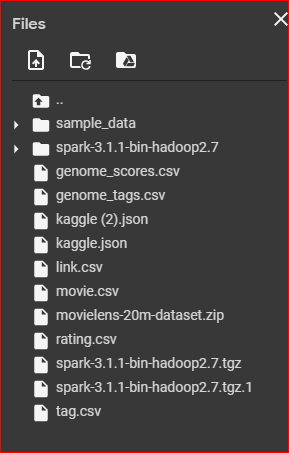

files in local environment